# Importing important packages 

In [1]:
## Importing important stuff
import random
import numpy as np
import pandas as pd
from PIL import Image 
import tifffile as tiff
             ###############
#plotting
import matplotlib.pyplot as plt
from plotly.offline import iplot
import plotly.graph_objs as go
            ####################
#machine learning stuff
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.utils.np_utils import to_categorical   
###
from keras import models
from keras import layers
###
import pickle as pkl
import time

Using TensorFlow backend.


# Loading data

In [2]:
x= np.load('bd_aug_256_new.npy')
y= np.load('gd_aug_256_new.npy')

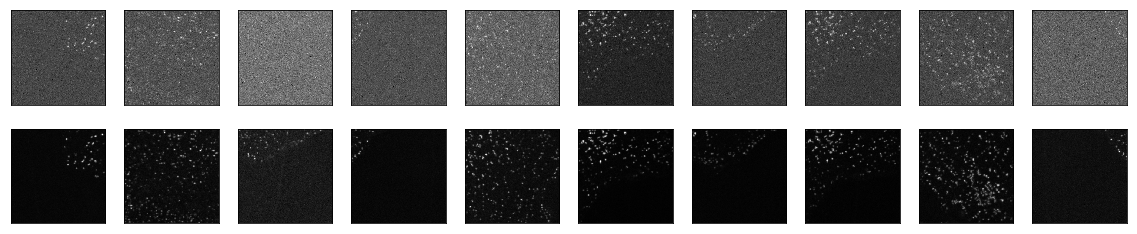

In [3]:
#checking correspondance 
#####check for correspondance
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x[i].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
        # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(y[i].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [4]:
#normalizing 
print(x.max())
print(x.min())
print(y.max())
print(y.min())

265.0
0.0
2734.0
82.0


In [5]:
x = x/2734.0
y = y/2734.0

In [6]:
#Splitting
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [7]:
#printing shapes 
print('shape of x_train is ', x_train.shape)
print('shape of y_train is ', y_train.shape)
print('shape of x_test is ', x_test.shape)
print('shape of y_test is ', y_test.shape)

shape of x_train is  (12000, 256, 256)
shape of y_train is  (12000, 256, 256)
shape of x_test is  (3000, 256, 256)
shape of y_test is  (3000, 256, 256)


In [8]:
#reshaping for the fitting
x_train = x_train.reshape(x_train.shape[0], 256,256,1)
x_test = x_test.reshape(x_test.shape[0], 256,256,1)
y_train = y_train.reshape(y_train.shape[0], 256,256,1)
y_test = y_test.reshape(y_test.shape[0], 256,256,1)

In [9]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(12000, 256, 256, 1)
(12000, 256, 256, 1)
(3000, 256, 256, 1)
(3000, 256, 256, 1)


# Creating Network

In [10]:
import keras
from keras.models import load_model
from keras.datasets import cifar10
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras import backend as K

import os
import pickle
import numpy as np
#import cv2

In [11]:
inputs = Input((256, 256, 1)) # 256
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs) 
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) # 128 
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) # 64 
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)  # 32 
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)   #16
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)   #4
conv6 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool5)
conv6 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv6)
pool6 = MaxPooling2D(pool_size=(2, 2))(conv6)  #2
conv7 = Conv2D(2048, (3, 3), activation='relu', padding='same')(pool6)
conv7 = Conv2D(2048, (3, 3), activation='relu', padding='same')(conv7)
pool7 = MaxPooling2D(pool_size=(2, 2))(conv7)   #1
conv8 = Conv2D(4096, (3, 3), activation='relu', padding='same')(pool7)
conv8 = Conv2D(4096, (3, 3), activation='relu', padding='same')(conv8)


In [12]:
up9 = concatenate([Conv2DTranspose(2048, (2, 2), strides=(2, 2), padding='same')(conv8), conv7], axis=3) #4
conv9 = Conv2D(2048, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(2048, (3, 3), activation='relu', padding='same')(conv9)
#
up10 = concatenate([Conv2DTranspose(1024, (2, 2), strides=(2, 2), padding='same')(conv9), conv6], axis=3) #8
conv10 = Conv2D(1024, (3, 3), activation='relu', padding='same')(up10)
conv10 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv10)
#
up11 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv10), conv5], axis=3) #16
conv11 = Conv2D(512, (3, 3), activation='relu', padding='same')(up11)
conv11 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv11)
#
up12 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv11), conv4], axis=3) #32
conv12 = Conv2D(256, (3, 3), activation='relu', padding='same')(up12)
conv12 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv12)
#
up13 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv12), conv3], axis=3) #64
conv13 = Conv2D(128, (3, 3), activation='relu', padding='same')(up13)
conv13 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv13)
#
up14 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv13), conv2], axis=3) #128
conv14 = Conv2D(64, (3, 3), activation='relu', padding='same')(up14)
conv14 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv14)
#
up15 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv14), conv1], axis=3) #256
conv15 = Conv2D(32, (3, 3), activation='relu', padding='same')(up15)
conv15 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv15)

#removed the activatio = 'sigmoid from the last layer'
conv16 = Conv2D(1, (3, 3), padding='same')(conv15)

In [13]:
model = Model(inputs=[inputs], outputs=[conv16])
model.compile(optimizer='adadelta', loss='binary_crossentropy',metrics=['mse'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 32) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

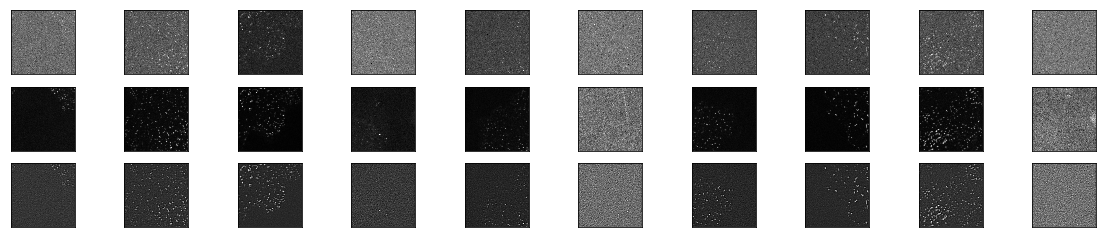

In [17]:
#checking correspondance 
#####check for correspondance
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
        # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(y_test[i].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(3, n, i + 1 + n + n)
    plt.imshow(pred[i].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [18]:
model.save('256_20_epoch.h5')

# Fitting

In [ ]:
#####
#Here I try monitoring the mse and minimizing that 
start=time.time()
from keras.callbacks import EarlyStopping, ModelCheckpoint

model.save_weights('model_256_init.h5')
callbacks = [EarlyStopping(monitor='val_mean_squared_error', patience=10),
             ModelCheckpoint(filepath='UNET_256.h5', monitor='val_mean_squared_error', save_best_only=True)]

model.load_weights('model_256_init.h5')
history = model.fit(x_train,y_train,
                              epochs=100,
                              batch_size=128,
                              verbose=1, # set to 0 for no printout while running
                              callbacks=callbacks, # Early stopping
                              validation_data=(x_test,y_test))

end=time.time()

print('fitting took ', (start-end)/60, 'minutes to run')

Train on 12000 samples, validate on 3000 samples
Epoch 1/100
12000/12000 [==============================] - 5901s 492ms/step - loss: 0.1887 - mean_squared_error: 3.1146e-04 - val_loss: 0.1830 - val_mean_squared_error: 3.1171e-04
Epoch 2/100
12000/12000 [==============================] - 5904s 492ms/step - loss: 0.1829 - mean_squared_error: 2.9253e-04 - val_loss: 0.1828 - val_mean_squared_error: 3.0170e-04
Epoch 3/100
12000/12000 [==============================] - 5886s 491ms/step - loss: 0.1828 - mean_squared_error: 2.8418e-04 - val_loss: 0.1823 - val_mean_squared_error: 2.6176e-04
Epoch 4/100
12000/12000 [==============================] - 5882s 490ms/step - loss: 0.1828 - mean_squared_error: 2.7896e-04 - val_loss: 0.1823 - val_mean_squared_error: 2.6616e-04
Epoch 5/100
12000/12000 [==============================] - 5878s 490ms/step - loss: 0.1827 - mean_squared_error: 2.7661e-04 - val_loss: 0.1823 - val_mean_squared_error: 2.6274e-04
Epoch 6/100
12000/12000 [==========================

In [ ]:
#taking forever, I can't

In [ ]:
#the input images might be previously seen by the network, so I think I should crop random images now 


In [15]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 32) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [16]:
pred = model.predict(x_test)